<a href="https://colab.research.google.com/github/tohurashehreen/ebird-bias-correction-using-gnn-and-xgbooster/blob/main/ebird_bias_correction_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
x= ((24341265) % 9 + 2) % 9
print(x)

2


In [ ]:
!pip install 'omegaconf<2.3'
!pip install pytorch-tabular --upgrade


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.3/79.3 kB 1.9 MB/s eta 0:00:00
  Attempting uninstall: omegaconf
    Found existing installation: omegaconf 2.3.0
    Uninstalling omegaconf-2.3.0:
      Successfully uninstalled omegaconf-2.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pytorch-tabular 1.1.1 requires omegaconf>=2.3.0, but you have omegaconf 2.2.3 which is incompatible.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 1.6 MB/s eta 0:00:00
  Attempting uninstall: omegaconf
    Found existing installation: omegaconf 2.2.3
    Uninstalling omegaconf-2.2.3:
      Successfully uninstalled omegaconf-2.2.3


In [ ]:

!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.2.0+cpu.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.2.0+cpu.html


Looking in links: https://data.pyg.org/whl/torch-2.2.0+cpu.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.8/511.8 kB 6.1 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.2.0+cpu.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.5 MB/s eta 0:00:00


In [ ]:
!pip install torch-geometric -f https://data.pyg.org/whl/torch-2.2.0+cpu.html

Looking in links: https://data.pyg.org/whl/torch-2.2.0+cpu.html


In [ ]:
!pip install "omegaconf<2.3.0"


In [ ]:
!pip install -U pytorch-tabular

  Using cached omegaconf-2.3.0-py3-none-any.whl.metadata (3.9 kB)
Using cached omegaconf-2.3.0-py3-none-any.whl (79 kB)
  Attempting uninstall: omegaconf
    Found existing installation: omegaconf 2.2.3
    Uninstalling omegaconf-2.2.3:
      Successfully uninstalled omegaconf-2.2.3


In [ ]:
import pandas as pd
import numpy as np
from google.colab import files
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from math import sqrt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from pytorch_tabular import TabularModel
from pytorch_tabular.models import TabTransformerConfig
from pytorch_tabular.config import DataConfig, TrainerConfig, OptimizerConfig

import torch
from torch_geometric.data import Data
from torch_geometric.utils import to_undirected

In [ ]:
uploaded = files.upload()               # choose ebird_merged.csv
df = pd.read_csv("ebird_merged.csv")

Saving ebird_merged.csv to ebird_merged (6).csv


In [ ]:

# 2️⃣  Target clean‑up: kill the “X” plague
df["OBSERVATION COUNT"] = pd.to_numeric(
    df["OBSERVATION COUNT"].replace("X", np.nan),  # X = unknown count
    errors="coerce"
)
df["OBSERVATION COUNT"].fillna(1, inplace=True)    # treat unknowns as 1 bird

# 3️⃣  Toss junk columns (pure IDs / ultra‑sparse text)
junk = [
    "GLOBAL UNIQUE IDENTIFIER", "TAXON CONCEPT ID",
    "SUBSPECIES COMMON NAME", "SUBSPECIES SCIENTIFIC NAME",
    "EXOTIC CODE", "OBSERVER ORCID ID_obs",
    "SAMPLING EVENT IDENTIFIER", "GROUP IDENTIFIER_obs",
    "CHECKLIST COMMENTS_obs", "SPECIES COMMENTS",
    *[c for c in df.columns if "_meta" in c],        # all *_meta duplicates
    *[c for c in df.columns if "LAST EDITED" in c]
]
df.drop(columns=[c for c in junk if c in df.columns], inplace=True)

# 4️⃣  Datetime split
df["OBSERVATION DATE_obs"] = pd.to_datetime(df["OBSERVATION DATE_obs"], errors="coerce")
df["YEAR"]  = df["OBSERVATION DATE_obs"].dt.year
df["MONTH"] = df["OBSERVATION DATE_obs"].dt.month
df["DOW"]   = df["OBSERVATION DATE_obs"].dt.dayofweek
df.drop(columns=["OBSERVATION DATE_obs", "TIME OBSERVATIONS STARTED_obs"], inplace=True)

# 5️⃣  Brutal one‑liner: every remaining object → numbers
for col in df.select_dtypes(include="object").columns:
    # first try to make it numeric (handles things like "3.5")
    df[col] = pd.to_numeric(df[col], errors="ignore")
    # if it’s STILL object, force category codes
    if df[col].dtype == "object":
        df[col] = df[col].astype("category").cat.codes

# 6️⃣  Features / target split
X = df.drop(columns=["OBSERVATION COUNT"])
y = df["OBSERVATION COUNT"]

# 7️⃣  Train / test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 8️⃣  XGBoost—no more whining 🎯
xgb = XGBRegressor(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    n_jobs=-1
)
xgb.fit(X_train, y_train)
preds = xgb.predict(X_test)

mse = mean_squared_error(y_test, preds)
print("✅  RMSE:", sqrt(mse))
print("✅  R²  :", r2_score(y_test, preds))




<ipython-input-4-88ffd4b3ffa4>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["OBSERVATION COUNT"].fillna(1, inplace=True)    # treat unknowns as 1 bird
<ipython-input-4-88ffd4b3ffa4>:30: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(df[col], errors="ignore")
<ipython-input-4-88ffd4b3ffa4>:30: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_num

✅  RMSE: 8.143621148186941
✅  R²  : 0.7018135179877139


In [ ]:
import pytorch_tabular
import torch
import omegaconf

print("PyTorch Tabular:", pytorch_tabular.__version__)
print("Torch:", torch.__version__)
print("OmegaConf:", omegaconf.__version__)


PyTorch Tabular: 1.1.1
Torch: 2.6.0+cu124
OmegaConf: 2.3.0


In [ ]:
# Reset dataframe for TabTransformer preprocessing
df = pd.read_csv("ebird_merged.csv")

# Basic preprocessing same as before
df["OBSERVATION COUNT"] = pd.to_numeric(
    df["OBSERVATION COUNT"].replace("X", np.nan),
    errors="coerce"
)
# Fix the deprecated inplace warning
df["OBSERVATION COUNT"] = df["OBSERVATION COUNT"].fillna(1)
df.drop(columns=[c for c in junk if c in df.columns], inplace=True)

# Datetime processing
df["OBSERVATION DATE_obs"] = pd.to_datetime(df["OBSERVATION DATE_obs"], errors="coerce")
df["YEAR"] = df["OBSERVATION DATE_obs"].dt.year
df["MONTH"] = df["OBSERVATION DATE_obs"].dt.month
df["DOW"] = df["OBSERVATION DATE_obs"].dt.dayofweek
df.drop(columns=["OBSERVATION DATE_obs", "TIME OBSERVATIONS STARTED_obs"], inplace=True)

# Identify categorical and continuous columns
categorical_cols = []
continuous_cols = []
for col in df.columns:
    if col == "OBSERVATION COUNT":
        continue
    if df[col].dtype == 'object':
        categorical_cols.append(col)
    elif df[col].nunique() < 20 and df[col].dtype in ['int64', 'float64']:
        categorical_cols.append(col)
    else:
        continuous_cols.append(col)

# Convert categorical columns to strings (required by TabTransformer)
for col in categorical_cols:
    df[col] = df[col].astype(str)

print("\n===== Training TabTransformer Model =====")
print(f"Categorical columns: {len(categorical_cols)}")
print(f"Continuous columns: {len(continuous_cols)}")

# Data Config
data_config = DataConfig(
    target=['OBSERVATION COUNT'],
    continuous_cols=continuous_cols,
    categorical_cols=categorical_cols,
    normalize_continuous_features=True
)

# Optimizer Config
optimizer_config = OptimizerConfig()

# Trainer Config
trainer_config = TrainerConfig(
    max_epochs=15,
    batch_size=256,
    early_stopping_patience=5,
    checkpoints=None,  # Simplified - don't save checkpoints
)

# Transformer Model Config
model_config = TabTransformerConfig(
    task="regression",
    input_embed_dim=32,
    num_heads=4,
    num_attn_blocks=6,
    embedding_dropout=0.1,
    ff_dropout=0.1,
    learning_rate=1e-3,
    head="LinearHead",
    head_config={"layers": "64-32"}
)

# Create and train model - added optimizer_config
tab_model = TabularModel(
    data_config=data_config,
    model_config=model_config,
    optimizer_config=optimizer_config,
    trainer_config=trainer_config
)

# Split data
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

try:
    # Make sure we have tensor data
    print("Preparing data for TabTransformer...")

    # Train
    print("Starting TabTransformer training...")
    tab_model.fit(train=train_df, validation=test_df)

    # Evaluate
    result = tab_model.evaluate(test_df)
    print("📊 TabTransformer Model Results:")
    print(f"Test MSE: {result[0]['test_loss']}")
    print(f"Test RMSE: {sqrt(result[0]['test_loss'])}")

    # Get predictions for R² calculation
    pred_df = tab_model.predict(test_df)
    r2 = r2_score(test_df["OBSERVATION COUNT"], pred_df["prediction"])
    print(f"Test R²: {r2}")
except Exception as e:
    print(f"Error during TabTransformer training: {e}")
    print("\nTroubleshooting tips:")
    print("1. Check current pytorch_tabular API with: pip show pytorch_tabular")
    print("2. Install specific version: pip install pytorch_tabular==0.8.0")
    print("3. Check the library documentation for your specific version")

    # Try a simpler alternative approach with default parameters
    print("\nAttempting simplified TabTransformer setup:")
    try:
        # Very basic configuration
        data_config = DataConfig(
            target=['OBSERVATION COUNT'],
            continuous_cols=continuous_cols,
            categorical_cols=categorical_cols
        )

        trainer_config = TrainerConfig()

        model_config = TabTransformerConfig(
            task="regression"
        )

        tab_model = TabularModel(
            data_config=data_config,
            model_config=model_config,
            trainer_config=trainer_config
        )

        print("Training with simplified configuration...")
        tab_model.fit(train=train_df, validation=test_df)
        print("Training complete!")
    except Exception as e2:
        print(f"Simplified approach also failed: {e2}")

INFO:pytorch_tabular.tabular_model:Experiment Tracking is turned off
INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_tabular.tabular_model:Preparing the DataLoaders
INFO:pytorch_tabular.tabular_datamodule:Setting up the datamodule for regression task



===== Training TabTransformer Model =====
Categorical columns: 33
Continuous columns: 8
Preparing data for TabTransformer...
Starting TabTransformer training...


/usr/local/lib/python3.11/dist-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_encoded[col].fillna(self._imputed, inplace=True)
/usr/local/lib/python3.11/dist-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting value

┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type                   ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ TabTransformerBackbone │  173 K │ train │
│ 1 │ _embedding_layer │ Embedding2dLayer       │ 19.5 K │ train │
│ 2 │ _head            │ LinearHead             │ 70.3 K │ train │
│ 3 │ loss             │ MSELoss                │      0 │ train │
└───┴──────────────────┴────────────────────────┴────────┴───────┘

Trainable params: 262 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 262 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 190                                                                                         
Modules in eval mode: 0

Output()

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches 
(16) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if
you want to see logs for the training epoch.

INFO:pytorch_tabular.tabular_model:Training the model completed
/usr/local/lib/python3.11/dist-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_encoded[col].fillna(self._imputed, inplace=True)
/usr/local/lib/python3.11/dist-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never wo

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │            nan            │
│  test_mean_squared_error  │            nan            │
└───────────────────────────┴───────────────────────────┘

📊 TabTransformer Model Results:
Test MSE: nan
Test RMSE: nan


/usr/local/lib/python3.11/dist-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_encoded[col].fillna(self._imputed, inplace=True)
/usr/local/lib/python3.11/dist-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting value

Error during TabTransformer training: 'prediction'

Troubleshooting tips:
1. Check current pytorch_tabular API with: pip show pytorch_tabular
2. Install specific version: pip install pytorch_tabular==0.8.0
3. Check the library documentation for your specific version

Attempting simplified TabTransformer setup:
Simplified approach also failed: Cannot merge with a None config
    full_key: 
    object_type=dict


In [ ]:
import pandas as pd
import numpy as np
from google.colab import files
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from math import sqrt

# For custom PyTorch implementation
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Upload dataset
print("Upload the ebird_merged.csv file:")
uploaded = files.upload()
df = pd.read_csv("ebird_merged.csv")
print(f"Dataset loaded with shape: {df.shape}")

# ==================== Data Preprocessing ====================

# Target clean‑up: replace "X" with NaN and convert to numeric
df["OBSERVATION COUNT"] = pd.to_numeric(
    df["OBSERVATION COUNT"].replace("X", np.nan),
    errors="coerce"
)
df["OBSERVATION COUNT"] = df["OBSERVATION COUNT"].fillna(1)  # treat unknowns as 1 bird

# Toss junk columns (pure IDs / ultra‑sparse text)
junk = [
    "GLOBAL UNIQUE IDENTIFIER", "TAXON CONCEPT ID",
    "SUBSPECIES COMMON NAME", "SUBSPECIES SCIENTIFIC NAME",
    "EXOTIC CODE", "OBSERVER ORCID ID_obs",
    "SAMPLING EVENT IDENTIFIER", "GROUP IDENTIFIER_obs",
    "CHECKLIST COMMENTS_obs", "SPECIES COMMENTS",
    *[c for c in df.columns if "_meta" in c],        # all *_meta duplicates
    *[c for c in df.columns if "LAST EDITED" in c]
]
df.drop(columns=[c for c in junk if c in df.columns], inplace=True)

# Datetime split
df["OBSERVATION DATE_obs"] = pd.to_datetime(df["OBSERVATION DATE_obs"], errors="coerce")
df["YEAR"] = df["OBSERVATION DATE_obs"].dt.year
df["MONTH"] = df["OBSERVATION DATE_obs"].dt.month
df["DOW"] = df["OBSERVATION DATE_obs"].dt.dayofweek
df.drop(columns=["OBSERVATION DATE_obs", "TIME OBSERVATIONS STARTED_obs"], inplace=True)

# Handle categorical data
categorical_cols = []
continuous_cols = []

for col in df.columns:
    if col == "OBSERVATION COUNT":
        continue
    # Check if column should be categorical
    if df[col].dtype == "object" or (df[col].nunique() < 20 and df[col].dtype in ["int64", "float64"]):
        categorical_cols.append(col)
        # Convert to category codes
        if df[col].dtype == "object":
            df[col] = df[col].astype("category").cat.codes
    else:
        continuous_cols.append(col)

print(f"Categorical columns: {len(categorical_cols)}")
print(f"Continuous columns: {len(continuous_cols)}")

# ==================== XGBoost Model ====================

print("\n===== Training XGBoost Model =====")

# Features / target split
X = df.drop(columns=["OBSERVATION COUNT"])
y = df["OBSERVATION COUNT"]

# Train / test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost model
xgb = XGBRegressor(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    n_jobs=-1
)
xgb.fit(X_train, y_train)
preds = xgb.predict(X_test)

# Evaluate XGBoost model
mse = mean_squared_error(y_test, preds)
rmse = sqrt(mse)
r2 = r2_score(y_test, preds)
print(f"✅ XGBoost RMSE: {rmse:.4f}")
print(f"✅ XGBoost R²: {r2:.4f}")

# ==================== Custom PyTorch Transformer Model ====================

print("\n===== Implementing Custom PyTorch Transformer Model =====")

# Create a custom Dataset class
class BirdDataset(Dataset):
    def __init__(self, X, y=None, categorical_cols=None, continuous_cols=None):
        self.categorical_cols = categorical_cols if categorical_cols else []
        self.continuous_cols = continuous_cols if continuous_cols else []

        # Convert to tensors
        if categorical_cols and len(categorical_cols) > 0:
            self.X_cat = torch.tensor(X[categorical_cols].values, dtype=torch.long)
        else:
            self.X_cat = None

        # Scale continuous features
        if continuous_cols and len(continuous_cols) > 0:
            self.scaler = StandardScaler()
            self.X_cont = torch.tensor(self.scaler.fit_transform(X[continuous_cols]), dtype=torch.float32)
        else:
            self.X_cont = None

        self.y = torch.tensor(y.values, dtype=torch.float32) if y is not None else None

    def __len__(self):
        return len(self.X_cat) if self.X_cat is not None else len(self.X_cont)

    def __getitem__(self, idx):
        data = {}
        if self.X_cat is not None:
            data['categorical'] = self.X_cat[idx]
        if self.X_cont is not None:
            data['continuous'] = self.X_cont[idx]

        if self.y is not None:
            return data, self.y[idx]
        return data

class TabTransformer(nn.Module):
    def __init__(self, cat_dims, cont_dims, emb_dim=32, num_heads=4, num_layers=6, ff_dim=128, dropout=0.1):
        super().__init__()

        # Embedding layers for categorical features
        self.cat_dims = cat_dims
        self.emb_dim = emb_dim
        self.has_categorical = len(cat_dims) > 0

        if self.has_categorical:
            self.embeddings = nn.ModuleList([
                nn.Embedding(dim, emb_dim) for dim in cat_dims
            ])
            self.pos_embedding = nn.Parameter(torch.randn(1, len(cat_dims), emb_dim))

            # Transformer encoder for categorical features
            encoder_layer = nn.TransformerEncoderLayer(
                d_model=emb_dim,
                nhead=num_heads,
                dim_feedforward=ff_dim,
                dropout=dropout,
                batch_first=True
            )
            self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Continuous feature processing
        self.cont_dims = cont_dims
        self.has_continuous = cont_dims > 0

        if self.has_continuous:
            self.cont_projection = nn.Linear(cont_dims, emb_dim)

        # Output head
        if self.has_categorical and self.has_continuous:
            total_dim = len(cat_dims) * emb_dim + emb_dim
        elif self.has_categorical:
            total_dim = len(cat_dims) * emb_dim
        elif self.has_continuous:
            total_dim = emb_dim
        else:
            raise ValueError("Model must have either categorical or continuous features")

        self.head = nn.Sequential(
            nn.Linear(total_dim, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        cat_features = None
        cont_features = None

        # Process categorical features
        if self.has_categorical and 'categorical' in x:
            categorical = x['categorical']
            # Apply embeddings
            cat_embeddings = [emb(categorical[:, i]) for i, emb in enumerate(self.embeddings)]
            cat_embeddings = torch.stack(cat_embeddings, dim=1)  # [batch, num_cat, emb_dim]

            # Add positional encoding
            cat_embeddings = cat_embeddings + self.pos_embedding

            # Apply transformer
            cat_features = self.transformer(cat_embeddings)
            cat_features = cat_features.reshape(cat_features.size(0), -1)  # Flatten

        # Process continuous features
        if self.has_continuous and 'continuous' in x:
            continuous = x['continuous']
            cont_features = self.cont_projection(continuous)

        # Combine features
        if cat_features is not None and cont_features is not None:
            combined = torch.cat([cat_features, cont_features], dim=1)
        elif cat_features is not None:
            combined = cat_features
        elif cont_features is not None:
            combined = cont_features
        else:
            raise ValueError("No features provided to the model")

        # Apply output head
        return self.head(combined).squeeze()

# Training function
def train_model(model, train_loader, val_loader, device, epochs=10, lr=0.001):
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_val_loss = float('inf')
    best_model = None

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0
        for batch_data, batch_targets in train_loader:
            # Move data to device
            if isinstance(batch_data, dict):
                for k in batch_data:
                    batch_data[k] = batch_data[k].to(device)
            else:
                batch_data = batch_data.to(device)
            batch_targets = batch_targets.to(device)

            # Forward pass
            try:
                outputs = model(batch_data)
                loss = criterion(outputs, batch_targets)

                # Backward pass and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
            except Exception as e:
                print(f"Error in training batch: {e}")
                print(f"Data keys: {batch_data.keys() if isinstance(batch_data, dict) else 'not a dict'}")
                if isinstance(batch_data, dict):
                    for k, v in batch_data.items():
                        print(f"  {k} shape: {v.shape}")
                raise e

        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_data, batch_targets in val_loader:
                # Move data to device
                if isinstance(batch_data, dict):
                    for k in batch_data:
                        batch_data[k] = batch_data[k].to(device)
                else:
                    batch_data = batch_data.to(device)
                batch_targets = batch_targets.to(device)

                # Forward pass
                try:
                    outputs = model(batch_data)
                    loss = criterion(outputs, batch_targets)
                    val_loss += loss.item()
                except Exception as e:
                    print(f"Error in validation batch: {e}")
                    raise e

        # Average loss over batches
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model.state_dict().copy()

    # Load best model
    if best_model is not None:
        model.load_state_dict(best_model)

    return model

# Evaluation function
def evaluate_model(model, test_loader, device):
    model.eval()
    predictions = []
    targets = []

    with torch.no_grad():
        for batch_data, batch_targets in test_loader:
            # Move data to device
            if isinstance(batch_data, dict):
                for k in batch_data:
                    batch_data[k] = batch_data[k].to(device)
            else:
                batch_data = batch_data.to(device)

            # Forward pass
            outputs = model(batch_data)

            # Store predictions and targets
            predictions.extend(outputs.cpu().numpy())
            targets.extend(batch_targets.numpy())

    # Calculate metrics
    mse = mean_squared_error(targets, predictions)
    rmse = sqrt(mse)
    r2 = r2_score(targets, predictions)

    return rmse, r2, predictions

# ==================== Run the Custom PyTorch Model ====================

try:
    # Prepare data
    X_train, X_test, y_train, y_test = train_test_split(
        df.drop(columns=["OBSERVATION COUNT"]),
        df["OBSERVATION COUNT"],
        test_size=0.2,
        random_state=42
    )

    # Ensure non-empty categorical and continuous columns
    print(f"Checking categorical columns: {len(categorical_cols)} columns")
    print(f"Checking continuous columns: {len(continuous_cols)} columns")

    # Verify all columns exist in dataframe
    missing_cat = [col for col in categorical_cols if col not in X_train.columns]
    missing_cont = [col for col in continuous_cols if col not in X_train.columns]

    if missing_cat:
        print(f"Warning: Missing categorical columns: {missing_cat}")
        categorical_cols = [col for col in categorical_cols if col in X_train.columns]

    if missing_cont:
        print(f"Warning: Missing continuous columns: {missing_cont}")
        continuous_cols = [col for col in continuous_cols if col in X_train.columns]

    # Get categorical dimensions (num unique values per category)
    cat_dims = []
    if categorical_cols:
        cat_dims = [int(X_train[col].nunique()) + 1 for col in categorical_cols]  # +1 for potential unseen values
        print(f"Categorical dimensions: {cat_dims}")

    # Create datasets
    print("Creating datasets...")
    train_dataset = BirdDataset(X_train, y_train, categorical_cols, continuous_cols)
    test_dataset = BirdDataset(X_test, y_test, categorical_cols, continuous_cols)

    # Verify dataset contents
    sample = train_dataset[0]
    print(f"Sample data keys: {sample[0].keys()}")
    if 'categorical' in sample[0]:
        print(f"Categorical sample shape: {sample[0]['categorical'].shape}")
    if 'continuous' in sample[0]:
        print(f"Continuous sample shape: {sample[0]['continuous'].shape}")

    # Create data loaders
    batch_size = 256
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # Initialize model
    print("Initializing model...")
    model = TabTransformer(
        cat_dims=cat_dims,
        cont_dims=len(continuous_cols),
        emb_dim=32,
        num_heads=4,
        num_layers=6,
        ff_dim=128,
        dropout=0.1
    )

    # Check for GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Train model
    print("Starting training...")
    epochs = 10
    model = train_model(model, train_loader, test_loader, device, epochs=epochs)

    # Evaluate model
    rmse, r2, predictions = evaluate_model(model, test_loader, device)
    print(f"\n📊 Custom TabTransformer Results:")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²: {r2:.4f}")

    # Compare with XGBoost
    print("\n📊 Model Comparison:")
    print(f"XGBoost RMSE: {sqrt(mean_squared_error(y_test, preds)):.4f}")
    print(f"XGBoost R²: {r2_score(y_test, preds):.4f}")
    print(f"TabTransformer RMSE: {rmse:.4f}")
    print(f"TabTransformer R²: {r2:.4f}")

except Exception as e:
    print(f"Error during custom PyTorch model training: {e}")
    import traceback
    traceback.print_exc()

    # Fallback to simpler model if custom model fails
    print("\n⚠️ Custom model failed, trying a simpler PyTorch model")

    try:
        # Simple MLP model as fallback
        class SimpleMLPModel(nn.Module):
            def __init__(self, input_dim):
                super().__init__()
                self.model = nn.Sequential(
                    nn.Linear(input_dim, 128),
                    nn.ReLU(),
                    nn.Dropout(0.2),
                    nn.Linear(128, 64),
                    nn.ReLU(),
                    nn.Dropout(0.2),
                    nn.Linear(64, 1)
                )

            def forward(self, x):
                return self.model(x).squeeze()

        # Create a simpler dataset that just concatenates all features
        class SimpleDataset(Dataset):
            def __init__(self, X, y=None):
                self.X = torch.tensor(X.values, dtype=torch.float32)
                self.y = torch.tensor(y.values, dtype=torch.float32) if y is not None else None

            def __len__(self):
                return len(self.X)

            def __getitem__(self, idx):
                if self.y is not None:
                    return self.X[idx], self.y[idx]
                return self.X[idx]

        # Prepare simple model
        print("Preparing simple MLP model...")
        X_train_simple = X_train.copy()
        X_test_simple = X_test.copy()

        # One-hot encode any remaining categorical columns
        for col in X_train_simple.select_dtypes(include=['category', 'object']).columns:
            X_train_simple[col] = X_train_simple[col].astype('category').cat.codes
            X_test_simple[col] = X_test_simple[col].astype('category').cat.codes

        # Scale all features
        scaler = StandardScaler()
        X_train_simple = pd.DataFrame(
            scaler.fit_transform(X_train_simple),
            columns=X_train_simple.columns
        )
        X_test_simple = pd.DataFrame(
            scaler.transform(X_test_simple),
            columns=X_test_simple.columns
        )

        # Create datasets and loaders
        train_dataset = SimpleDataset(X_train_simple, y_train)
        test_dataset = SimpleDataset(X_test_simple, y_test)

        train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=256)

        # Train simple model
        simple_model = SimpleMLPModel(X_train_simple.shape[1])
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        simple_model.to(device)

        # Simple training loop
        criterion = nn.MSELoss()
        optimizer = optim.Adam(simple_model.parameters(), lr=0.001)

        for epoch in range(10):
            # Training
            simple_model.train()
            train_loss = 0
            for X_batch, y_batch in train_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)

                outputs = simple_model(X_batch)
                loss = criterion(outputs, y_batch)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                train_loss += loss.item()

            print(f"Epoch {epoch+1}/10, Train Loss: {train_loss/len(train_loader):.4f}")

        # Evaluate
        simple_model.eval()
        with torch.no_grad():
            predictions = []
            targets = []

            for X_batch, y_batch in test_loader:
                X_batch = X_batch.to(device)
                outputs = simple_model(X_batch)

                predictions.extend(outputs.cpu().numpy())
                targets.extend(y_batch.numpy())

        # Calculate metrics
        mse = mean_squared_error(targets, predictions)
        rmse = sqrt(mse)
        r2 = r2_score(targets, predictions)

        print(f"\n📊 Simple MLP Results:")
        print(f"RMSE: {rmse:.4f}")
        print(f"R²: {r2:.4f}")

        # Compare with XGBoost
        print("\n📊 Model Comparison:")
        print(f"XGBoost RMSE: {sqrt(mean_squared_error(y_test, preds)):.4f}")
        print(f"XGBoost R²: {r2_score(y_test, preds):.4f}")
        print(f"Simple MLP RMSE: {rmse:.4f}")
        print(f"Simple MLP R²: {r2:.4f}")

    except Exception as e2:
        print(f"Simple model also failed: {e2}")
        print("✅ At least XGBoost model completed successfully")

Upload the ebird_merged.csv file:


Saving ebird_merged.csv to ebird_merged (8).csv
Dataset loaded with shape: (4863, 84)
Categorical columns: 33
Continuous columns: 8

===== Training XGBoost Model =====
✅ XGBoost RMSE: 8.1436
✅ XGBoost R²: 0.7018

===== Implementing Custom PyTorch Transformer Model =====
Checking categorical columns: 33 columns
Checking continuous columns: 8 columns
Categorical dimensions: [5, 123, 123, 11, 6, 11, 1, 2, 2, 2, 2, 2, 2, 3, 3, 1, 1, 98, 102, 3, 58, 4, 4, 4, 1, 1, 1, 6, 3, 3, 2, 3, 1]
Creating datasets...
Sample data keys: dict_keys(['categorical', 'continuous'])
Categorical sample shape: torch.Size([33])
Continuous sample shape: torch.Size([8])
Initializing model...
Using device: cpu
Starting training...
Error in training batch: index out of range in self
Data keys: dict_keys(['categorical', 'continuous'])
  categorical shape: torch.Size([256, 33])
  continuous shape: torch.Size([256, 8])
Error during custom PyTorch model training: index out of range in self

⚠️ Custom model failed, trying

Traceback (most recent call last):
  File "<ipython-input-12-e97535ac6844>", line 406, in <cell line: 0>
    model = train_model(model, train_loader, test_loader, device, epochs=epochs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-12-e97535ac6844>", line 266, in train_model
    raise e
  File "<ipython-input-12-e97535ac6844>", line 251, in train_model
    outputs = model(batch_data)
              ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py", line 1739, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py", line 1750, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-12-e97535ac6844>", line 199, in forward
    cat_embeddings = [emb(categorical[:, i]) for i, emb in enumerate(self.embe

Epoch 1/10, Train Loss: nan
Epoch 2/10, Train Loss: nan
Epoch 3/10, Train Loss: nan
Epoch 4/10, Train Loss: nan
Epoch 5/10, Train Loss: nan
Epoch 6/10, Train Loss: nan
Epoch 7/10, Train Loss: nan
Epoch 8/10, Train Loss: nan
Epoch 9/10, Train Loss: nan
Epoch 10/10, Train Loss: nan
Simple model also failed: Input contains NaN.
✅ At least XGBoost model completed successfully


In [ ]:

label_cols = [col for col in X.columns if X[col].dtype == "object"]  # Or whatever logic you use

# 🧠 Tabular Config
data_config = DataConfig(
    target=['OBSERVATION COUNT'],
    continuous_cols=[col for col in X.columns if col not in label_cols],
    categorical_cols=label_cols
)

trainer_config = TrainerConfig(auto_lr_find=True, max_epochs=10, batch_size=256)  # ✅ KEEP THIS ONE
model_config = CategoryEmbeddingModelConfig(
    task="regression",
    layers="128-64",  # Add some model layers
)


# 💥 Build & Fit Model
tab_model = TabularModel(
    data_config=data_config,
    model_config=model_config,
    trainer_config=trainer_config
)

df_train = df.copy()
tab_model.fit(df_train)
result = tab_model.evaluate(df_train)
print("📊 Tabular Model Result:", result)

# 🧠 GNN for Regression
obs_enc = LabelEncoder().fit_transform(df['OBSERVER ID_obs'].astype(str))
nodes = torch.tensor(obs_enc, dtype=torch.long)

features = torch.tensor(X.values, dtype=torch.float)
targets = torch.tensor(y.values, dtype=torch.float)

# 🕸️ Create Edges Between Different Observers
edges = []
for i in range(len(obs_enc)-1):
    if obs_enc[i] != obs_enc[i+1]:
        edges.append([i, i+1])
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
edge_index = to_undirected(edge_index)

# 🔐 GNN Data Object
graph_data = Data(x=features, y=targets, edge_index=edge_index)
print("📦 GNN Graph Data:", graph_data)


INFO:pytorch_tabular.tabular_model:Experiment Tracking is turned off


ValueError: Cannot merge with a None config
    full_key: 
    object_type=dict

In [ ]:

# 🔥 GNN for Regression
!pip install torch-geometric
import torch
from torch_geometric.data import Data

obs_enc = LabelEncoder().fit_transform(df['OBSERVER ID_obs'].astype(str))
nodes = torch.tensor(obs_enc, dtype=torch.long)

features = torch.tensor(X.values, dtype=torch.float)
targets = torch.tensor(y.values, dtype=torch.float)

# Simple edge_index (connect sequential obs from different observers)
from torch_geometric.utils import to_undirected

edges = []
for i in range(len(obs_enc)-1):
    if obs_enc[i] != obs_enc[i+1]:
        edges.append([i, i+1])
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
edge_index = to_undirected(edge_index)

graph_data = Data(x=features, y=targets, edge_index=edge_index)
print(graph_data)


Data(x=[4863, 41], edge_index=[2, 8810], y=[4863])


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


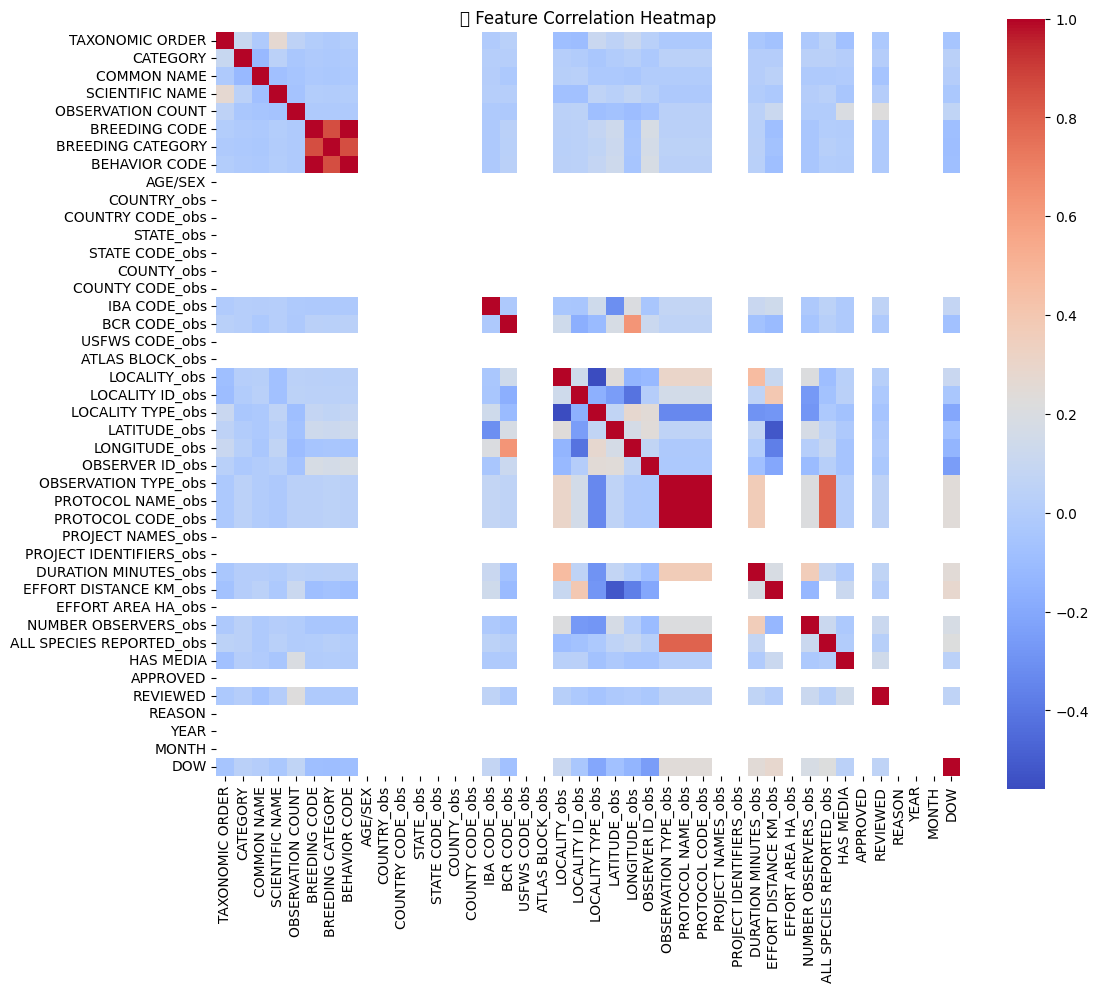

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
corr = df.corr(numeric_only=True)

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap="coolwarm", annot=False, square=True)
plt.title("📊 Feature Correlation Heatmap")
plt.show()


<Figure size 1200x800 with 0 Axes>

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


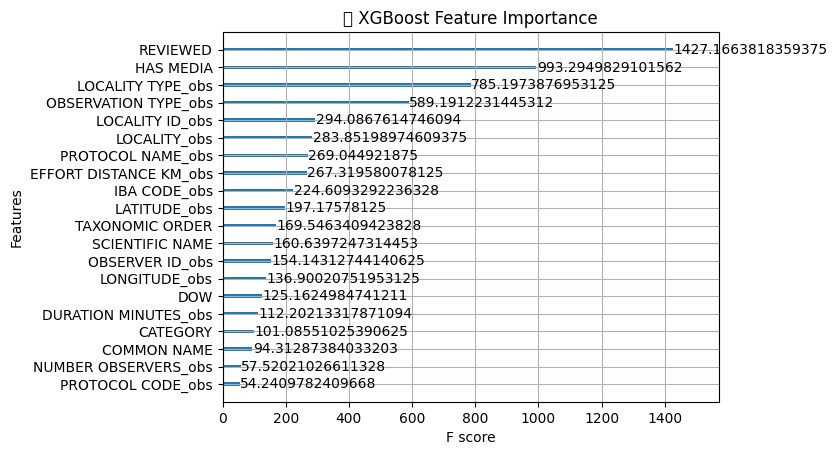

In [ ]:
from xgboost import plot_importance

plt.figure(figsize=(12, 8))
plot_importance(xgb, max_num_features=20, importance_type='gain')
plt.title("🎯 XGBoost Feature Importance")
plt.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


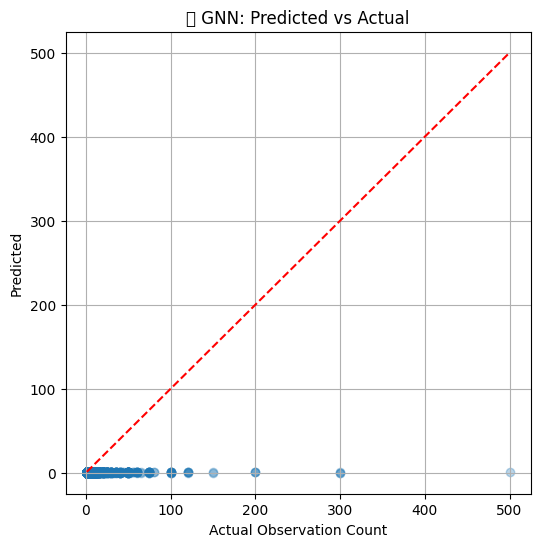

✅ GNN RMSE: 16.13117141320212
✅ GNN R²  : -0.09858083724975586


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Dummy prediction placeholder — replace with your actual GNN model outputs
gnn_preds = torch.rand_like(targets)  # Replace with your GNN model's predictions

# Plot Predicted vs. Actual
plt.figure(figsize=(6, 6))
plt.scatter(targets.numpy(), gnn_preds.detach().numpy(), alpha=0.3)
plt.plot([targets.min(), targets.max()], [targets.min(), targets.max()], 'r--')
plt.xlabel("Actual Observation Count")
plt.ylabel("Predicted")
plt.title("📈 GNN: Predicted vs Actual")
plt.grid(True)
plt.show()

# Error Metrics
mse = mean_squared_error(targets.numpy(), gnn_preds.detach().numpy())
r2 = r2_score(targets.numpy(), gnn_preds.detach().numpy())

print("✅ GNN RMSE:", np.sqrt(mse))
print("✅ GNN R²  :", r2)
